Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=c040d053e196947e7b1a85175240e4b1c5f0d35f714b212d5e0377d091bb86b9
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 29.2 MB/s 
     |████████████████████████████████| 163 kB 74.0 MB/s 
[3612, 6261, 4857, 6420, 5943, 3344, 1768, 337, 4857, 337, 6

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-23 03:35:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-23 03:35:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-23 03:35:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3460 words (3093 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 100)          655400    
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 140, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 140, 43)           1849      
                                                                 
Total params: 826,692
Trainable params: 826,692
Non-trainable params:

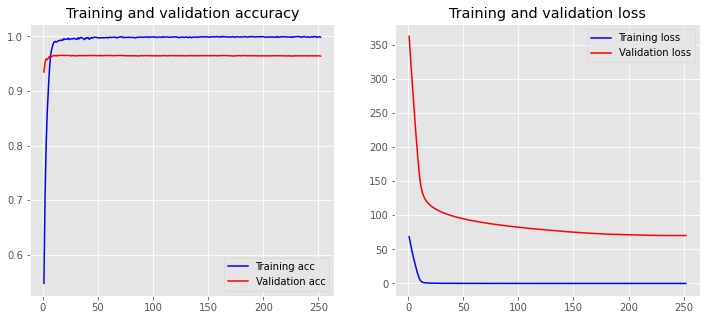

6/6 [==============================] - 3s 67ms/step
F1-score: 64.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7777777777777778,0.7857142857142857,0.7817258883248731,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.2777777777777778,0.37037037037037035,0.3174603174603175,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.45714285714285713,0.8,0.5818181818181818,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.84375,0.9310344827586207,0.8852459016393444,87.0
Material,0.5181347150259067,0.6329113924050633,0.5698005698005699,316.0
Material-Descriptor,0.42045454545454547,0.4157303370786517,0.4180790960451977,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.8521739130434782,0.9245283018867925,0.8868778280542987,212.0
Operation,0.704119850187266,0.7899159663865546,0.7445544554455447,2

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3463 words (3096 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 100)          656000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 827,292
Trainable params: 827,292
Non-trainable param

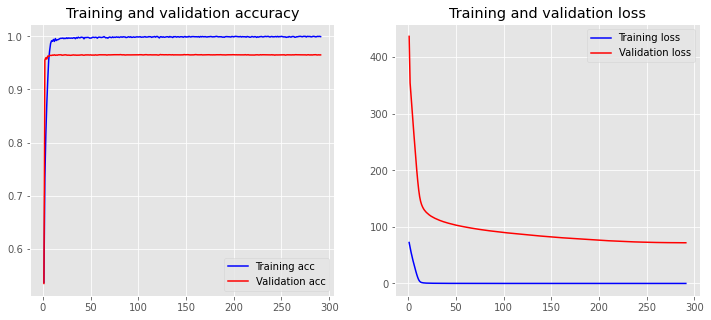

6/6 [==============================] - 3s 66ms/step
F1-score: 65.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8041237113402062,0.7959183673469388,0.8,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.4482758620689655,0.48148148148148145,0.4642857142857143,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.42105263157894735,0.8,0.5517241379310345,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.8723404255319149,0.9425287356321839,0.9060773480662984,87.0
Material,0.5680628272251309,0.6867088607594937,0.6217765042979942,316.0
Material-Descriptor,0.4020618556701031,0.43820224719101125,0.41935483870967744,89.0
Meta,0.15,0.23076923076923078,0.18181818181818185,13.0
Nonrecipe-Material,0.09523809523809523,0.08,0.08695652173913043,25.0


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3463 words (3098 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 100)          656200    
                                                                 
 bidirectional_2 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 827,492
Trainable params: 827,492
Non-trainable param

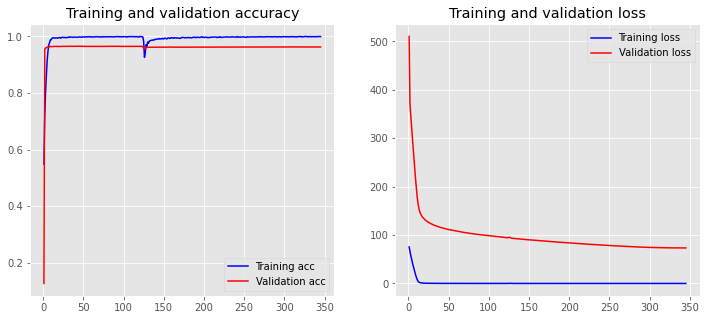

6/6 [==============================] - 3s 67ms/step
F1-score: 65.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7766990291262136,0.8163265306122449,0.7960199004975125,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.25806451612903225,0.5925925925925926,0.3595505617977528,27.0
Characterization-Apparatus,0.1111111111111111,0.09090909090909091,0.09999999999999999,11.0
Condition-Misc,0.37209302325581395,0.8,0.5079365079365079,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.8913043478260869,0.9425287356321839,0.9162011173184358,87.0
Material,0.5656836461126006,0.6677215189873418,0.6124818577648766,316.0
Material-Descriptor,0.42718446601941745,0.4943820224719101,0.4583333333333333,89.0
Meta,0.23529411764705882,0.3076923076923077,0.26666666666666666,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3468 words (3099 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 140, 100)          656800    
                                                                 
 bidirectional_3 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 828,092
Trainable params: 828,092
Non-trainable param

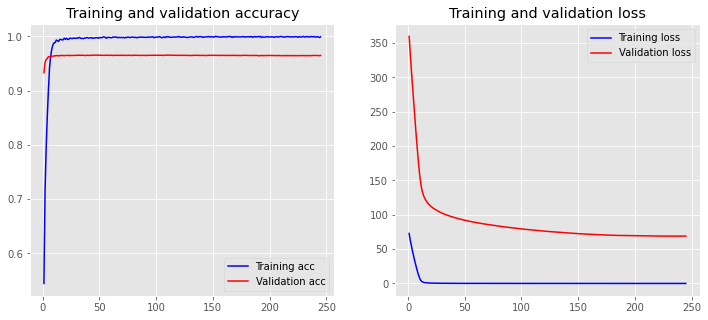

6/6 [==============================] - 3s 67ms/step
F1-score: 65.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7156862745098039,0.7448979591836735,0.7300000000000001,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.25,0.3333333333333333,0.28571428571428575,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.37209302325581395,0.8,0.5079365079365079,20.0
Condition-Type,0.16666666666666666,1.0,0.2857142857142857,1.0
Condition-Unit,0.8736842105263158,0.9540229885057471,0.9120879120879121,87.0
Material,0.5405405405405406,0.6962025316455697,0.6085753803596129,316.0
Material-Descriptor,0.41,0.4606741573033708,0.43386243386243384,89.0
Meta,0.15384615384615385,0.15384615384615385,0.15384615384615385,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.880530973

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3459 words (3099 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 140, 100)          655900    
                                                                 
 bidirectional_4 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 827,192
Trainable params: 827,192
Non-trainable param

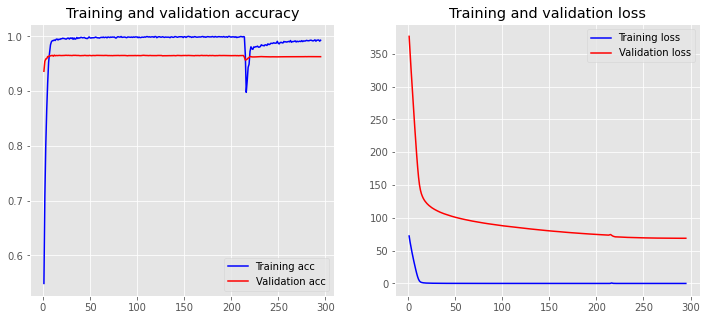

6/6 [==============================] - 3s 67ms/step
F1-score: 63.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6448598130841121,0.7040816326530612,0.673170731707317,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.2,0.07692307692307693,0.1111111111111111,13.0
Brand,0.34285714285714286,0.4444444444444444,0.3870967741935484,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.42105263157894735,0.8,0.5517241379310345,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.8817204301075269,0.9425287356321839,0.9111111111111111,87.0
Material,0.5275590551181102,0.6360759493670886,0.5767575322812052,316.0
Material-Descriptor,0.41237113402061853,0.449438202247191,0.43010752688172044,89.0
Meta,0.21428571428571427,0.23076923076923078,0.22222222222222224,13.0
Nonrecipe-Material,0.11111111

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3460 words (3097 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 140, 100)          655800    
                                                                 
 bidirectional_5 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 827,092
Trainable params: 827,092
Non-trainable param

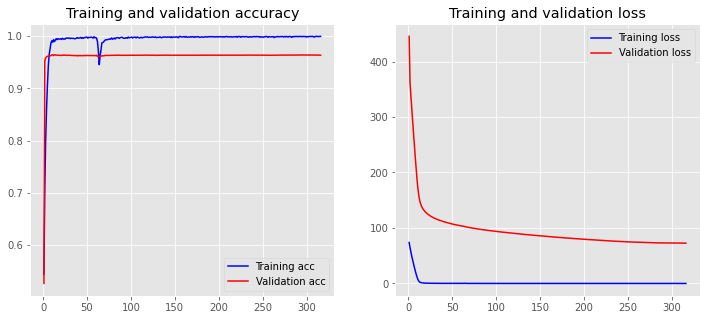

6/6 [==============================] - 3s 71ms/step
F1-score: 64.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.78125,0.7653061224489796,0.7731958762886597,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.2909090909090909,0.5925925925925926,0.39024390243902435,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.46875,0.75,0.5769230769230769,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.5259067357512953,0.6424050632911392,0.5783475783475783,316.0
Material-Descriptor,0.425531914893617,0.449438202247191,0.4371584699453552,89.0
Meta,0.3333333333333333,0.23076923076923078,0.27272727272727276,13.0
Nonrecipe-Material,0.08333333333333333,0.04,0.0540540

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3463 words (3093 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 140, 100)          655700    
                                                                 
 bidirectional_6 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 826,992
Trainable params: 826,992
Non-trainable param

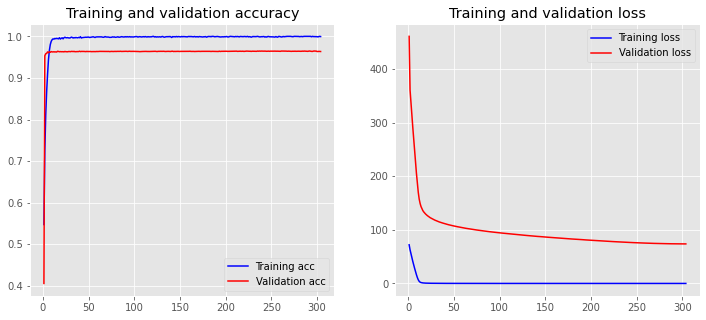

6/6 [==============================] - 3s 71ms/step
F1-score: 65.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7216494845360825,0.7142857142857143,0.7179487179487181,98.0
Apparatus-Descriptor,0.6,0.6666666666666666,0.631578947368421,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5,0.4074074074074074,0.44897959183673464,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.47058823529411764,0.8,0.5925925925925927,20.0
Condition-Type,0.16666666666666666,1.0,0.2857142857142857,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.5362694300518135,0.6550632911392406,0.5897435897435898,316.0
Material-Descriptor,0.3978494623655914,0.4157303370786517,0.4065934065934066,89.0
Meta,0.3,0.23076923076923078,0.2608695652173913,13.0
Nonrecipe-Material,0.2,0.04,0.06666666666666667,25.0
Number,0.8

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3458 words (3096 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 140, 100)          655500    
                                                                 
 bidirectional_7 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 826,792
Trainable params: 826,792
Non-trainable param

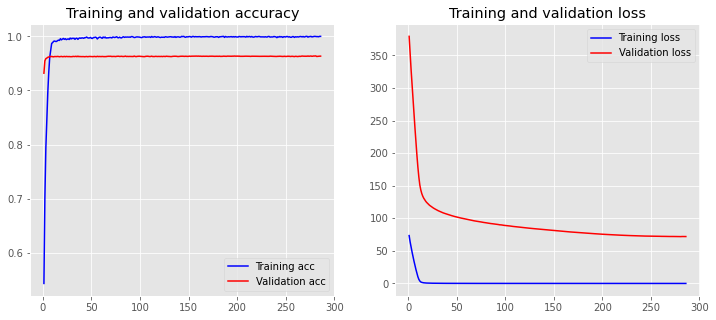

6/6 [==============================] - 3s 72ms/step
F1-score: 65.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6764705882352942,0.7040816326530612,0.69,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.4838709677419355,0.5555555555555556,0.5172413793103449,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.4444444444444444,0.8,0.5714285714285714,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.8571428571428571,0.9655172413793104,0.908108108108108,87.0
Material,0.5333333333333333,0.6582278481012658,0.5892351274787536,316.0
Material-Descriptor,0.4056603773584906,0.48314606741573035,0.441025641025641,89.0
Meta,0.4,0.3076923076923077,0.34782608695652173,13.0
Nonrecipe-Material,0.15384615384615385,0.08,0.10526315789473685,25.0
Number,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3461 words (3096 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 140, 100)          655800    
                                                                 
 bidirectional_8 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 827,092
Trainable params: 827,092
Non-trainable param

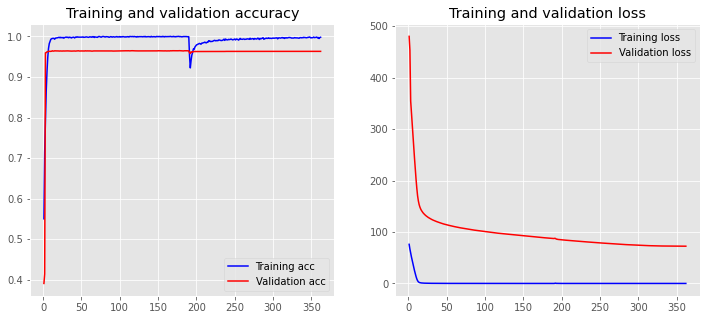

6/6 [==============================] - 3s 70ms/step
F1-score: 65.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7684210526315789,0.7448979591836735,0.7564766839378239,98.0
Apparatus-Descriptor,0.6,0.6666666666666666,0.631578947368421,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.2857142857142857,0.15384615384615385,0.2,13.0
Brand,0.23404255319148937,0.4074074074074074,0.29729729729729726,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5333333333333333,0.8,0.64,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.845360824742268,0.9425287356321839,0.8913043478260869,87.0
Material,0.5292620865139949,0.6582278481012658,0.5867418899858956,316.0
Material-Descriptor,0.4673913043478261,0.48314606741573035,0.47513812154696133,89.0
Meta,0.16666666666666666,0.23076923076923078,0.1935483870967742,13.0
Nonrecipe-Material,0.14285714285714285,0.04,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Converted 3457 words (3092 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 140, 100)          655000    
                                                                 
 bidirectional_9 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 826,292
Trainable params: 826,292
Non-trainable param

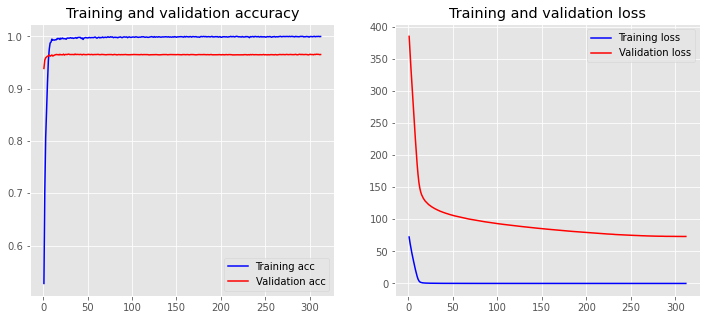

6/6 [==============================] - 3s 68ms/step
F1-score: 65.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8080808080808081,0.8163265306122449,0.8121827411167513,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.3870967741935484,0.4444444444444444,0.41379310344827586,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.3611111111111111,0.65,0.4642857142857143,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.8709677419354839,0.9310344827586207,0.9,87.0
Material,0.5621621621621622,0.6582278481012658,0.6064139941690962,316.0
Material-Descriptor,0.4117647058823529,0.39325842696629215,0.40229885057471265,89.0
Meta,0.2727272727272727,0.23076923076923078,0.24999999999999994,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3465 words (3100 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 140, 100)          656600    
                                                                 
 bidirectional_10 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 827,892
Trainable params: 827,892
Non-trainable para

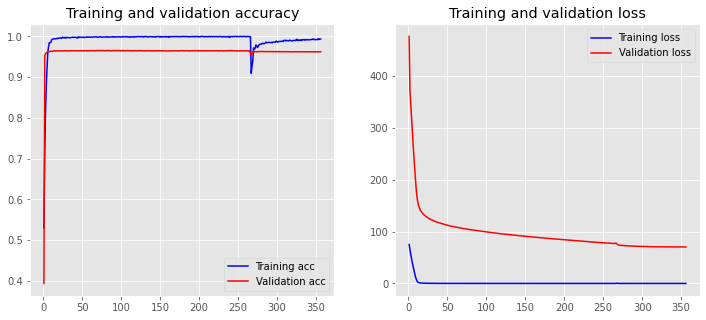

6/6 [==============================] - 3s 66ms/step
F1-score: 64.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8125,0.7959183673469388,0.8041237113402061,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.22916666666666666,0.4074074074074074,0.2933333333333333,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.3191489361702128,0.75,0.4477611940298508,20.0
Condition-Type,0.2,1.0,0.33333333333333337,1.0
Condition-Unit,0.8924731182795699,0.9540229885057471,0.9222222222222222,87.0
Material,0.5424657534246575,0.6265822784810127,0.5814977973568282,316.0
Material-Descriptor,0.3944954128440367,0.48314606741573035,0.43434343434343436,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.909523809

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3469 words (3100 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 140, 100)          657000    
                                                                 
 bidirectional_11 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 828,292
Trainable params: 828,292
Non-trainable para

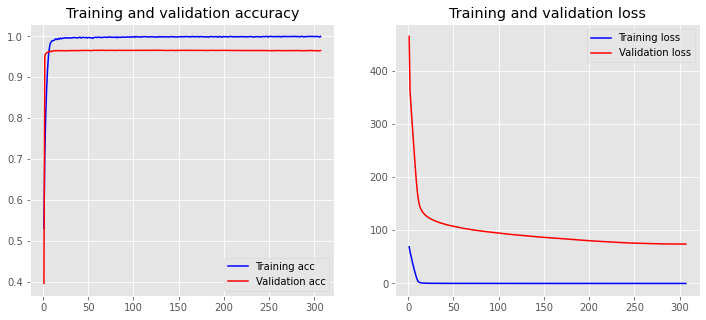

6/6 [==============================] - 3s 69ms/step
F1-score: 64.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7524752475247525,0.7755102040816326,0.7638190954773869,98.0
Apparatus-Descriptor,0.6,0.6666666666666666,0.631578947368421,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.25,0.07692307692307693,0.11764705882352941,13.0
Brand,0.38235294117647056,0.48148148148148145,0.4262295081967213,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.4666666666666667,0.7,0.56,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.8829787234042553,0.9540229885057471,0.9171270718232043,87.0
Material,0.5324324324324324,0.6234177215189873,0.5743440233236152,316.0
Material-Descriptor,0.4,0.42696629213483145,0.41304347826086957,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,0.14285714285714285,0.04,0.0625,25.0
N

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3475 words (3106 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 140, 100)          658200    
                                                                 
 bidirectional_12 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 829,492
Trainable params: 829,492
Non-trainable para

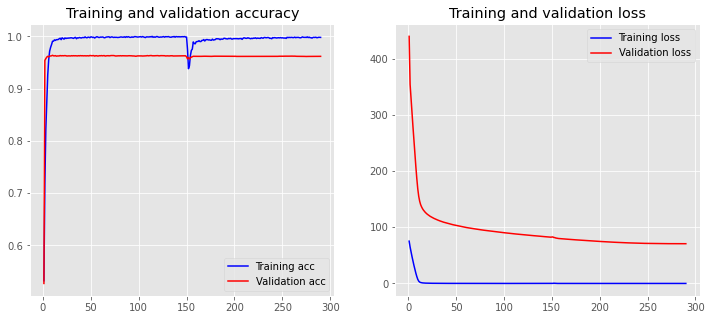

6/6 [==============================] - 3s 69ms/step
F1-score: 65.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6818181818181818,0.7653061224489796,0.721153846153846,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.37209302325581395,0.5925925925925926,0.45714285714285713,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.4838709677419355,0.75,0.5882352941176471,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9101123595505618,0.9310344827586207,0.9204545454545454,87.0
Material,0.49295774647887325,0.6645569620253164,0.5660377358490566,316.0
Material-Descriptor,0.44565217391304346,0.4606741573033708,0.4530386740331491,89.0
Meta,0.25,0.3076923076923077,0.27586206896551724,13.0
Nonrecipe-Material,0.25,0.08,0.12121212121212122,25.0
Num

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3467 words (3101 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 140, 100)          656900    
                                                                 
 bidirectional_13 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 828,192
Trainable params: 828,192
Non-trainable para

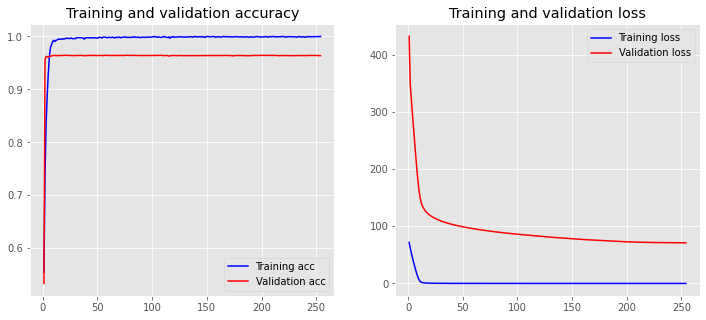

6/6 [==============================] - 3s 70ms/step
F1-score: 65.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7281553398058253,0.7653061224489796,0.7462686567164178,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.47058823529411764,0.5925925925925926,0.5245901639344261,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.39473684210526316,0.75,0.5172413793103448,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.5119617224880383,0.6772151898734177,0.5831062670299727,316.0
Material-Descriptor,0.45977011494252873,0.449438202247191,0.45454545454545453,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,0.07142857142857142,0.04,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3473 words (3099 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 140, 100)          657300    
                                                                 
 bidirectional_14 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 828,592
Trainable params: 828,592
Non-trainable para

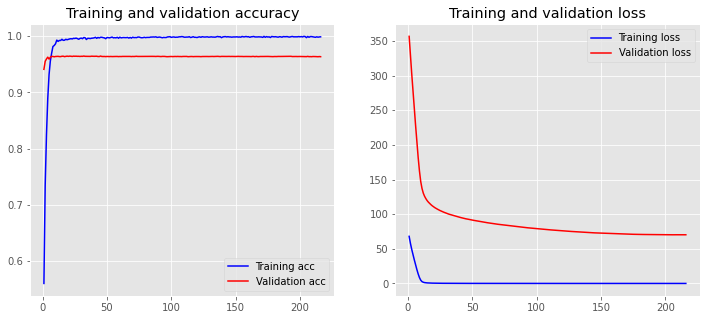

6/6 [==============================] - 3s 72ms/step
F1-score: 63.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7238095238095238,0.7755102040816326,0.7487684729064038,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.3076923076923077,0.4444444444444444,0.3636363636363637,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.34782608695652173,0.8,0.48484848484848486,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9,0.9310344827586207,0.9152542372881356,87.0
Material,0.5184210526315789,0.6234177215189873,0.5660919540229885,316.0
Material-Descriptor,0.39603960396039606,0.449438202247191,0.4210526315789474,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.8558951965065502,0.9245283018

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3465 words (3102 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 140, 100)          656800    
                                                                 
 bidirectional_15 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 828,092
Trainable params: 828,092
Non-trainable para

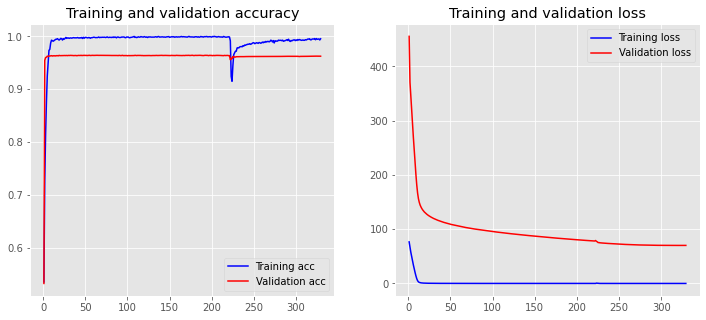

6/6 [==============================] - 3s 69ms/step
F1-score: 65.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7474747474747475,0.7551020408163265,0.7512690355329948,98.0
Apparatus-Descriptor,0.35294117647058826,0.6666666666666666,0.46153846153846156,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.42857142857142855,0.23076923076923078,0.3,13.0
Brand,0.32432432432432434,0.4444444444444444,0.375,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.41304347826086957,0.95,0.5757575757575758,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.5444743935309974,0.6392405063291139,0.5880640465793304,316.0
Material-Descriptor,0.4020618556701031,0.43820224719101125,0.41935483870967744,89.0
Meta,0.36363636363636365,0.3076923076923077,0.33333333333333337,13.0
Nonrecipe-Material,0.1111111111111111,0.04,0.058823529

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3469 words (3108 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 140, 100)          657800    
                                                                 
 bidirectional_16 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 829,092
Trainable params: 829,092
Non-trainable para

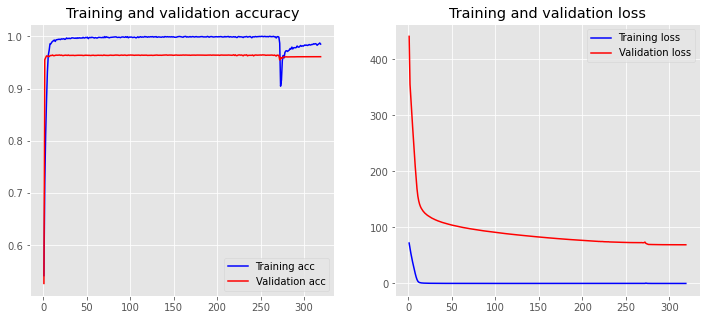

6/6 [==============================] - 3s 71ms/step
F1-score: 63.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6339285714285714,0.7244897959183674,0.6761904761904762,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.27586206896551724,0.5925925925925926,0.3764705882352941,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.34782608695652173,0.8,0.48484848484848486,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.8977272727272727,0.9080459770114943,0.9028571428571429,87.0
Material,0.47415730337078654,0.6677215189873418,0.5545335085413928,316.0
Material-Descriptor,0.4842105263157895,0.5168539325842697,0.5,89.0
Meta,0.16666666666666666,0.23076923076923078,0.1935483870967742,13.0
Nonrecipe-Material,0.07692307692307693,0.0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3470 words (3100 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 140, 100)          657100    
                                                                 
 bidirectional_17 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 828,392
Trainable params: 828,392
Non-trainable para

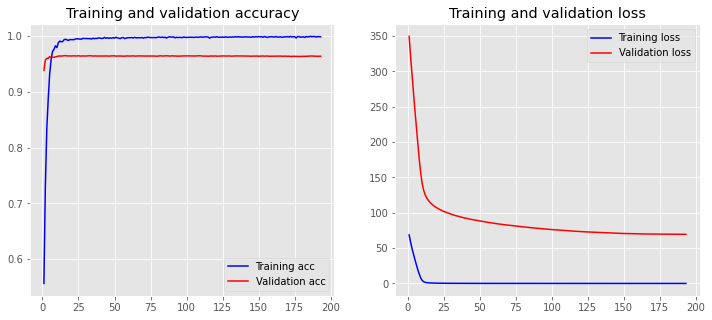

6/6 [==============================] - 3s 68ms/step
F1-score: 65.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.14285714285714285,0.14285714285714285,0.14285714285714285,7.0
Amount-Unit,0.7102803738317757,0.7755102040816326,0.7414634146341462,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.2608695652173913,0.4444444444444444,0.32876712328767116,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.42105263157894735,0.8,0.5517241379310345,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9101123595505618,0.9310344827586207,0.9204545454545454,87.0
Material,0.5125858123569794,0.7088607594936709,0.5949535192563082,316.0
Material-Descriptor,0.4431818181818182,0.43820224719101125,0.4406779661016949,89.0
Meta,0.21052631578947367,0.3076923076923077,0.25,13.0
Nonrecipe-Material,0.0,0.0,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3476 words (3112 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 140, 100)          658900    
                                                                 
 bidirectional_18 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 830,192
Trainable params: 830,192
Non-trainable para

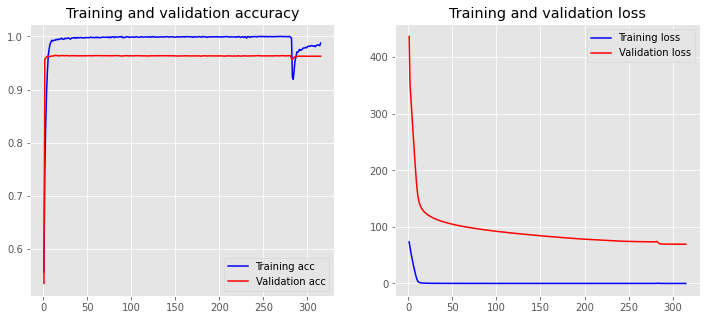

6/6 [==============================] - 3s 70ms/step
F1-score: 64.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.2857142857142857,0.2857142857142857,7.0
Amount-Unit,0.7244897959183674,0.7244897959183674,0.7244897959183674,98.0
Apparatus-Descriptor,0.42857142857142855,0.6666666666666666,0.5217391304347826,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.21212121212121213,0.5185185185185185,0.3010752688172043,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.45714285714285713,0.8,0.5818181818181818,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.8617021276595744,0.9310344827586207,0.8950276243093922,87.0
Material,0.592375366568915,0.6392405063291139,0.6149162861491629,316.0
Material-Descriptor,0.47674418604651164,0.4606741573033708,0.46857142857142864,89.0
Meta,0.4,0.3076923076923077,0.34782608695652173,13.0
Nonrecipe-Material,0.0,0.0,0.0,2

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Converted 3470 words (3107 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 140, 100)          657800    
                                                                 
 bidirectional_19 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 829,092
Trainable params: 829,092
Non-trainable para

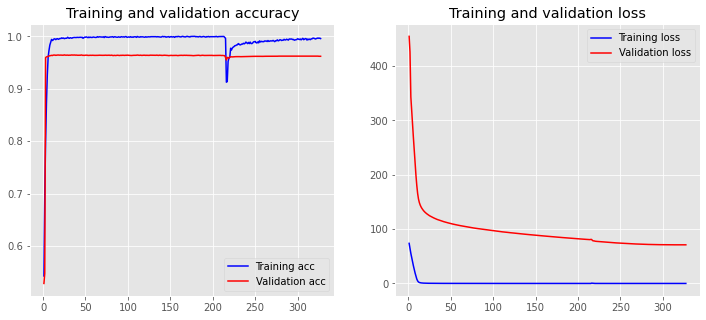

6/6 [==============================] - 3s 74ms/step
F1-score: 63.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6296296296296297,0.6938775510204082,0.6601941747572815,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.2727272727272727,0.6666666666666666,0.3870967741935484,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.425,0.85,0.5666666666666667,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.7788461538461539,0.9310344827586207,0.8481675392670157,87.0
Material,0.5157068062827225,0.6234177215189873,0.5644699140401147,316.0
Material-Descriptor,0.3942307692307692,0.4606741573033708,0.42487046632124353,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,0.09090909090909091,0.04,0.05555555555555555,25.0
Number

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3490 words (3123 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 140, 100)          661400    
                                                                 
 bidirectional_20 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 832,692
Trainable params: 832,692
Non-trainable para

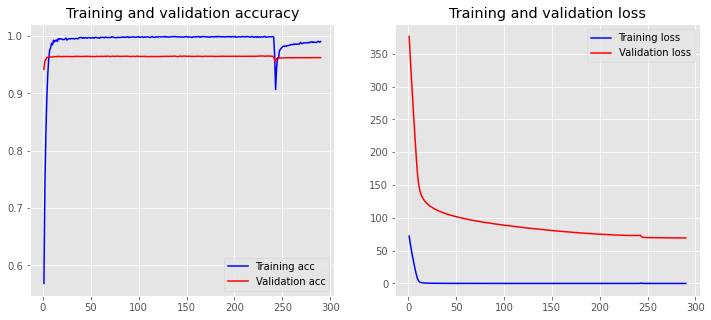

6/6 [==============================] - 3s 70ms/step
F1-score: 63.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6730769230769231,0.7142857142857143,0.6930693069306932,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.18518518518518517,0.18518518518518517,0.18518518518518517,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.42105263157894735,0.8,0.5517241379310345,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9318181818181818,0.9425287356321839,0.9371428571428572,87.0
Material,0.5268542199488491,0.6518987341772152,0.5827439886845828,316.0
Material-Descriptor,0.39805825242718446,0.4606741573033708,0.4270833333333333,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,0.0,0.0,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3478 words (3105 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 140, 100)          658400    
                                                                 
 bidirectional_21 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 829,692
Trainable params: 829,692
Non-trainable para

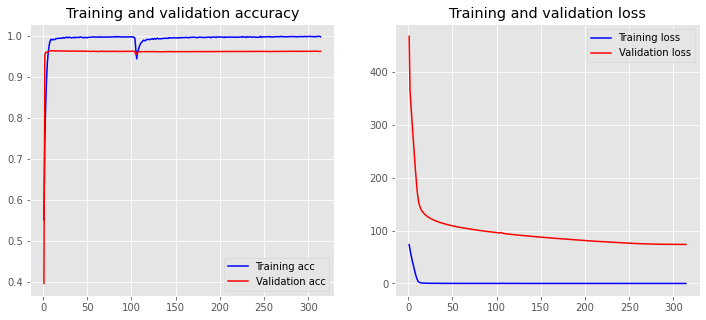

6/6 [==============================] - 3s 70ms/step
F1-score: 65.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6952380952380952,0.7448979591836735,0.7192118226600985,98.0
Apparatus-Descriptor,0.6,0.6666666666666666,0.631578947368421,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.4,0.5185185185185185,0.45161290322580644,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.42857142857142855,0.9,0.5806451612903225,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.865979381443299,0.9655172413793104,0.9130434782608695,87.0
Material,0.5036144578313253,0.6613924050632911,0.5718194254445965,316.0
Material-Descriptor,0.43333333333333335,0.43820224719101125,0.4357541899441341,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material,0.16666666666666666,0.04,0.06451612903225806,25.0
Number,0.89497716894977

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3478 words (3113 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 140, 100)          659200    
                                                                 
 bidirectional_22 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 830,492
Trainable params: 830,492
Non-trainable para

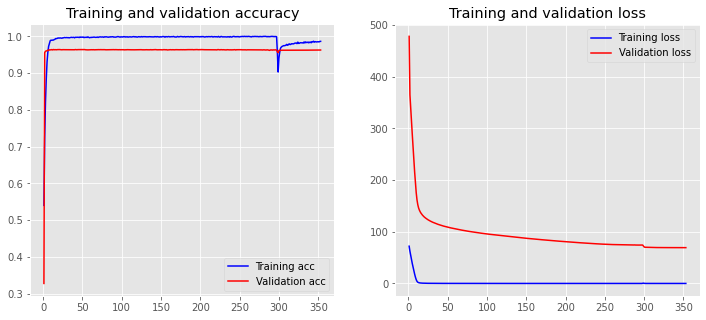

6/6 [==============================] - 3s 71ms/step
F1-score: 64.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7448979591836735,0.7448979591836735,0.7448979591836735,98.0
Apparatus-Descriptor,0.3333333333333333,0.5555555555555556,0.4166666666666667,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.4166666666666667,0.37037037037037035,0.39215686274509803,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.37209302325581395,0.8,0.5079365079365079,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.5449871465295629,0.6708860759493671,0.6014184397163119,316.0
Material-Descriptor,0.36538461538461536,0.42696629213483145,0.3937823834196891,89.0
Meta,0.25,0.3076923076923077,0.27586206896551724,13.0
Nonrecipe-Material,0.08695652173913043,0.0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3490 words (3111 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 140, 100)          660200    
                                                                 
 bidirectional_23 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,492
Trainable params: 831,492
Non-trainable para

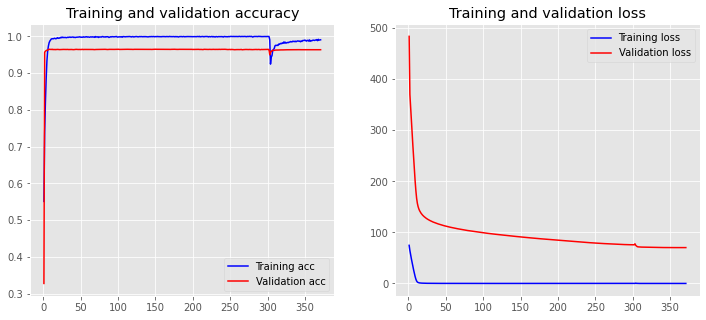

6/6 [==============================] - 3s 70ms/step
F1-score: 63.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7549019607843137,0.7857142857142857,0.7700000000000001,98.0
Apparatus-Descriptor,0.3125,0.5555555555555556,0.39999999999999997,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.375,0.23076923076923078,0.2857142857142857,13.0
Brand,0.2857142857142857,0.4444444444444444,0.34782608695652173,27.0
Characterization-Apparatus,0.05555555555555555,0.09090909090909091,0.06896551724137931,11.0
Condition-Misc,0.43902439024390244,0.9,0.5901639344262295,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.8631578947368421,0.9425287356321839,0.901098901098901,87.0
Material,0.513715710723192,0.6518987341772152,0.5746164574616457,316.0
Material-Descriptor,0.4,0.47191011235955055,0.43298969072164956,89.0
Meta,0.11538461538461539,0.23076923076923078,0.15384615384615388,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.8812785388

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3480 words (3103 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 140, 100)          658400    
                                                                 
 bidirectional_24 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 829,692
Trainable params: 829,692
Non-trainable para

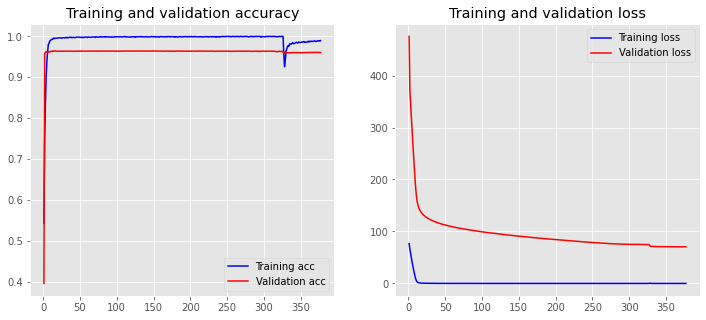

6/6 [==============================] - 3s 71ms/step
F1-score: 64.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6634615384615384,0.7040816326530612,0.6831683168316831,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.18181818181818182,0.4444444444444444,0.2580645161290322,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5357142857142857,0.75,0.6250000000000001,20.0
Condition-Type,0.2,1.0,0.33333333333333337,1.0
Condition-Unit,0.8709677419354839,0.9310344827586207,0.9,87.0
Material,0.5578635014836796,0.5949367088607594,0.5758039816232772,316.0
Material-Descriptor,0.40816326530612246,0.449438202247191,0.42780748663101603,89.0
Meta,0.4444444444444444,0.3076923076923077,0.3636363636363637,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.8857142857142857,0.8773584905660378,0.881516587677

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3499 words (3105 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 140, 100)          660500    
                                                                 
 bidirectional_25 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,792
Trainable params: 831,792
Non-trainable para

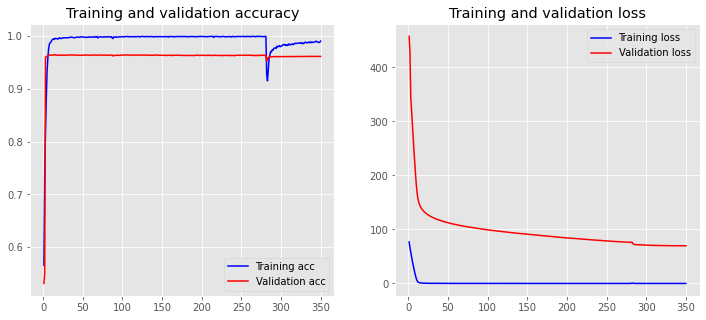

6/6 [==============================] - 3s 73ms/step
F1-score: 63.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.72,0.7346938775510204,0.7272727272727272,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.2,0.15384615384615385,0.17391304347826086,13.0
Brand,0.28888888888888886,0.48148148148148145,0.36111111111111105,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5,0.8,0.6153846153846154,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.84375,0.9310344827586207,0.8852459016393444,87.0
Material,0.5409836065573771,0.6265822784810127,0.5806451612903225,316.0
Material-Descriptor,0.3707865168539326,0.3707865168539326,0.3707865168539326,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.08333333333333333,0.04,0.05405405405405406,25.0
Number,0.8687782805429864,0.90566

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3475 words (3112 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 140, 100)          658800    
                                                                 
 bidirectional_26 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 830,092
Trainable params: 830,092
Non-trainable para

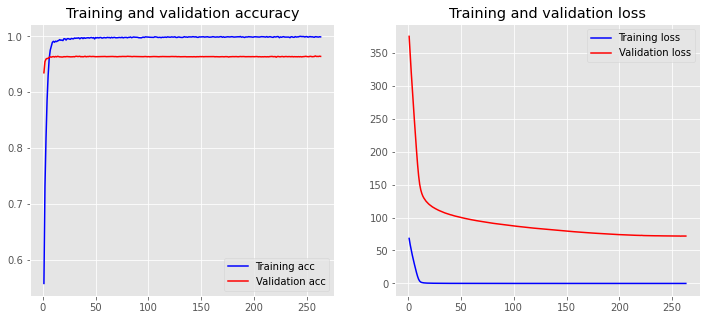

6/6 [==============================] - 3s 73ms/step
F1-score: 64.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7422680412371134,0.7346938775510204,0.7384615384615386,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.35294117647058826,0.4444444444444444,0.39344262295081966,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.46875,0.75,0.5769230769230769,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.8924731182795699,0.9540229885057471,0.9222222222222222,87.0
Material,0.49872122762148335,0.6170886075949367,0.5516265912305516,316.0
Material-Descriptor,0.43902439024390244,0.4044943820224719,0.42105263157894735,89.0
Meta,0.2,0.15384615384615385,0.17391304347826086,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.87387

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3473 words (3105 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 140, 100)          657900    
                                                                 
 bidirectional_27 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 829,192
Trainable params: 829,192
Non-trainable para

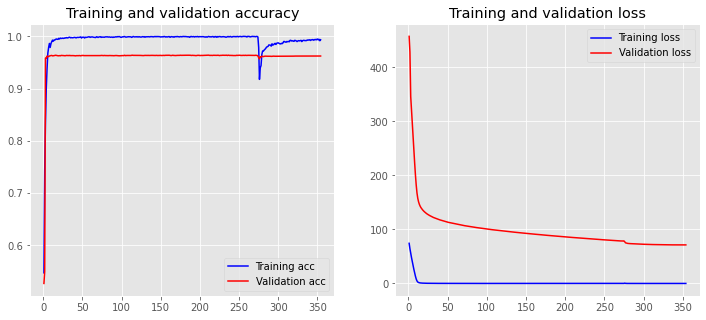

6/6 [==============================] - 4s 76ms/step
F1-score: 62.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7029702970297029,0.7244897959183674,0.7135678391959799,98.0
Apparatus-Descriptor,0.2631578947368421,0.5555555555555556,0.35714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.23880597014925373,0.5925925925925926,0.3404255319148936,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.4722222222222222,0.85,0.6071428571428571,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.8863636363636364,0.896551724137931,0.8914285714285715,87.0
Material,0.5335120643431636,0.629746835443038,0.5776487663280118,316.0
Material-Descriptor,0.3838383838383838,0.42696629213483145,0.4042553191489362,89.0
Meta,0.2727272727272727,0.23076923076923078,0.24999999999999994,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.855

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3485 words (3102 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 140, 100)          658800    
                                                                 
 bidirectional_28 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 830,092
Trainable params: 830,092
Non-trainable para

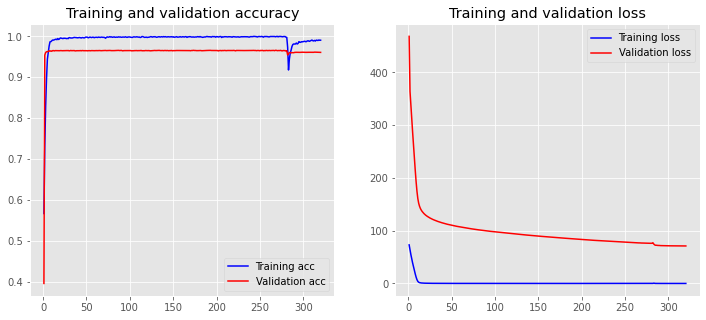

6/6 [==============================] - 4s 76ms/step
F1-score: 62.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6597938144329897,0.6530612244897959,0.6564102564102564,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.4,0.15384615384615385,0.2222222222222222,13.0
Brand,0.19047619047619047,0.2962962962962963,0.2318840579710145,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.40540540540540543,0.75,0.5263157894736842,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.7961165048543689,0.9425287356321839,0.863157894736842,87.0
Material,0.5813253012048193,0.6107594936708861,0.595679012345679,316.0
Material-Descriptor,0.4880952380952381,0.4606741573033708,0.47398843930635837,89.0
Meta,0.46153846153846156,0.46153846153846156,0.46153846153846156,13.0
Nonrecipe-Material,0.06,0.12,0.08,25.0
Number,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Converted 3490 words (3108 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 140, 100)          659900    
                                                                 
 bidirectional_29 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,192
Trainable params: 831,192
Non-trainable para

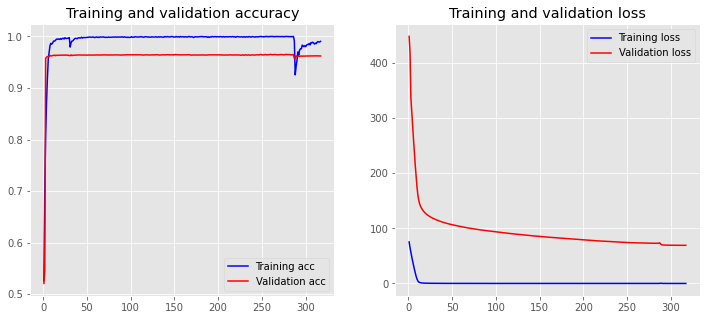

6/6 [==============================] - 3s 75ms/step
F1-score: 63.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6952380952380952,0.7448979591836735,0.7192118226600985,98.0
Apparatus-Descriptor,0.36363636363636365,0.4444444444444444,0.39999999999999997,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.1935483870967742,0.4444444444444444,0.2696629213483146,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.37254901960784315,0.95,0.5352112676056339,20.0
Condition-Type,0.3333333333333333,1.0,0.5,1.0
Condition-Unit,0.9425287356321839,0.9425287356321839,0.9425287356321839,87.0
Material,0.5623188405797102,0.6139240506329114,0.5869894099848714,316.0
Material-Descriptor,0.3894736842105263,0.4157303370786517,0.4021739130434782,89.0
Meta,0.4,0.3076923076923077,0.34782608695652173,13.0
Nonrecipe-Material,0.15384615384615385,0.08,0.10526315789473685,25.0
Number,0.8

In [15]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3490 words (3115 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 140, 100)          660600    
                                                                 
 bidirectional_30 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,892
Trainable params: 831,892
Non-trainable para

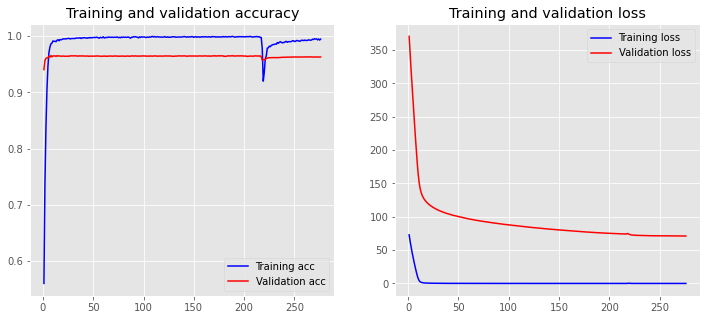

6/6 [==============================] - 3s 73ms/step
F1-score: 61.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7446808510638298,0.7142857142857143,0.7291666666666666,98.0
Apparatus-Descriptor,0.3076923076923077,0.4444444444444444,0.3636363636363637,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.18518518518518517,0.18518518518518517,0.18518518518518517,27.0
Characterization-Apparatus,0.05,0.09090909090909091,0.06451612903225806,11.0
Condition-Misc,0.30612244897959184,0.75,0.43478260869565216,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.84,0.9655172413793104,0.8983957219251336,87.0
Material,0.4911392405063291,0.6139240506329114,0.5457102672292545,316.0
Material-Descriptor,0.41346153846153844,0.48314606741573035,0.4455958549222798,89.0
Meta,0.23809523809523808,0.38461538461538464,0.2941176470588235,13.0
Nonrecipe-Material,0.0833333333333333

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3483 words (3114 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 140, 100)          659800    
                                                                 
 bidirectional_31 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,092
Trainable params: 831,092
Non-trainable para

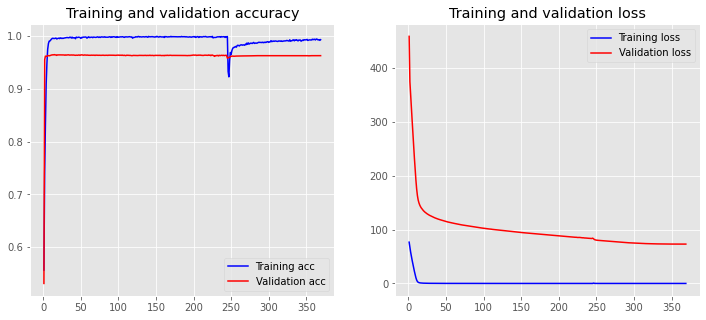

6/6 [==============================] - 4s 76ms/step
F1-score: 63.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7087378640776699,0.7448979591836735,0.7263681592039802,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.3,0.2222222222222222,0.25531914893617025,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.5038560411311054,0.620253164556962,0.5560283687943263,316.0
Material-Descriptor,0.38202247191011235,0.38202247191011235,0.3820224719101124,89.0
Meta,0.2,0.15384615384615385,0.17391304347826086,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.8995215311004785,0.88679245283

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3480 words (3112 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 140, 100)          659300    
                                                                 
 bidirectional_32 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 830,592
Trainable params: 830,592
Non-trainable para

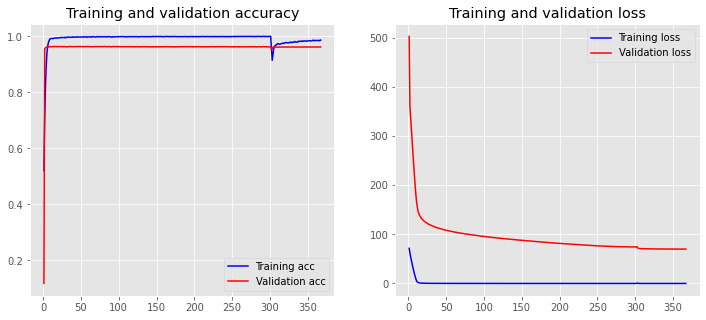

6/6 [==============================] - 3s 74ms/step
F1-score: 63.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.74,0.7551020408163265,0.7474747474747474,98.0
Apparatus-Descriptor,0.3333333333333333,0.6666666666666666,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.15384615384615385,0.21052631578947367,13.0
Brand,0.4230769230769231,0.4074074074074074,0.4150943396226415,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.47058823529411764,0.8,0.5925925925925927,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.8913043478260869,0.9425287356321839,0.9162011173184358,87.0
Material,0.4975728155339806,0.6487341772151899,0.5631868131868132,316.0
Material-Descriptor,0.3723404255319149,0.39325842696629215,0.3825136612021858,89.0
Meta,0.38461538461538464,0.38461538461538464,0.38461538461538464,13.0
Nonrecipe-Material,0.0,0.0,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3494 words (3111 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 140, 100)          660600    
                                                                 
 bidirectional_33 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,892
Trainable params: 831,892
Non-trainable para

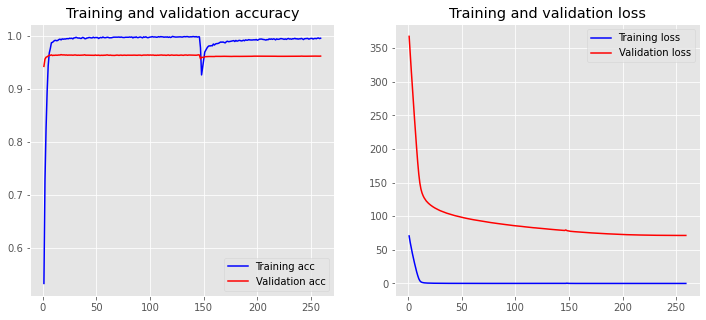

6/6 [==============================] - 3s 72ms/step
F1-score: 62.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.75,0.7653061224489796,0.7575757575757575,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.16363636363636364,0.3333333333333333,0.21951219512195122,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.4166666666666667,0.75,0.5357142857142857,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.8888888888888888,0.9195402298850575,0.903954802259887,87.0
Material,0.5157593123209169,0.569620253164557,0.5413533834586466,316.0
Material-Descriptor,0.46511627906976744,0.449438202247191,0.45714285714285713,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.09090909090909091,0.12,0.1034482758620

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3491 words (3114 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 140, 100)          660600    
                                                                 
 bidirectional_34 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,892
Trainable params: 831,892
Non-trainable para

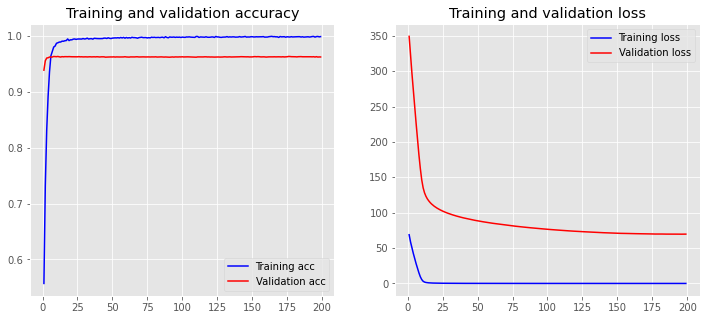

6/6 [==============================] - 4s 75ms/step
F1-score: 62.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7647058823529411,0.7959183673469388,0.7799999999999999,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.30952380952380953,0.48148148148148145,0.37681159420289856,27.0
Characterization-Apparatus,0.1,0.09090909090909091,0.09523809523809525,11.0
Condition-Misc,0.34146341463414637,0.7,0.4590163934426229,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.8817204301075269,0.9425287356321839,0.9111111111111111,87.0
Material,0.5106382978723404,0.6075949367088608,0.5549132947976879,316.0
Material-Descriptor,0.3645833333333333,0.39325842696629215,0.3783783783783784,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.8526785714285714,0.900943

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3493 words (3114 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 140, 100)          660800    
                                                                 
 bidirectional_35 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 832,092
Trainable params: 832,092
Non-trainable para

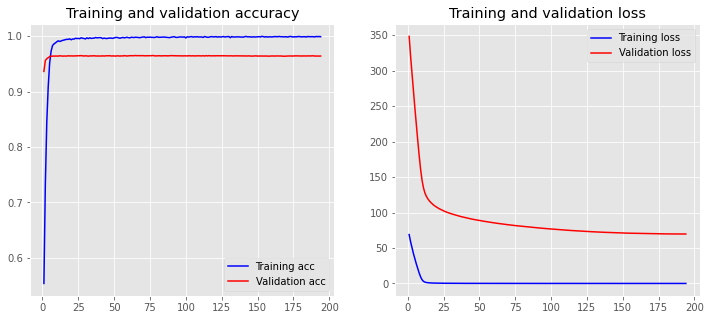

6/6 [==============================] - 4s 74ms/step
F1-score: 64.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7326732673267327,0.7551020408163265,0.743718592964824,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.4,0.15384615384615385,0.2222222222222222,13.0
Brand,0.32142857142857145,0.3333333333333333,0.32727272727272727,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.47368421052631576,0.9,0.6206896551724138,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.8631578947368421,0.9425287356321839,0.901098901098901,87.0
Material,0.49882903981264637,0.6740506329113924,0.5733512786002692,316.0
Material-Descriptor,0.45454545454545453,0.449438202247191,0.45197740112994345,89.0
Meta,0.25,0.15384615384615385,0.1904761904761905,13.0
Nonrecipe-Material,0.0,0.0,0.0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3496 words (3115 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 140, 100)          661200    
                                                                 
 bidirectional_36 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 832,492
Trainable params: 832,492
Non-trainable para

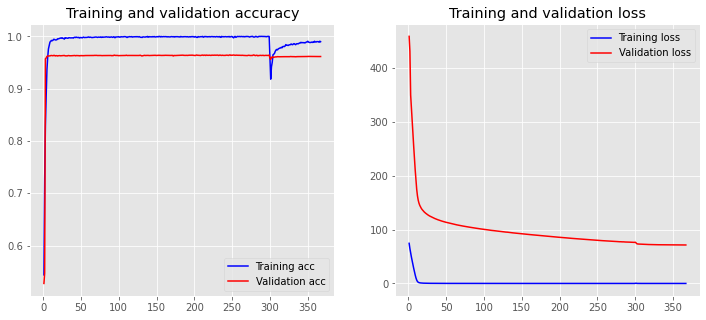

6/6 [==============================] - 4s 76ms/step
F1-score: 61.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7142857142857143,0.7142857142857143,0.7142857142857143,98.0
Apparatus-Descriptor,0.3333333333333333,0.5555555555555556,0.4166666666666667,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.18421052631578946,0.5185185185185185,0.27184466019417475,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.35714285714285715,0.75,0.48387096774193544,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.8723404255319149,0.9425287356321839,0.9060773480662984,87.0
Material,0.5079787234042553,0.6044303797468354,0.5520231213872833,316.0
Material-Descriptor,0.41346153846153844,0.48314606741573035,0.4455958549222798,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.07142857142857142,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3489 words (3116 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 140, 100)          660600    
                                                                 
 bidirectional_37 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,892
Trainable params: 831,892
Non-trainable para

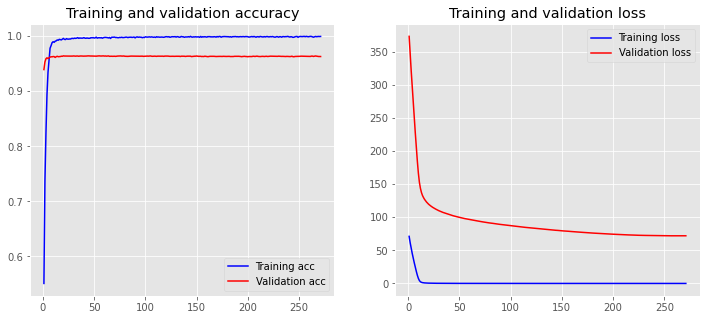

6/6 [==============================] - 4s 75ms/step
F1-score: 65.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7373737373737373,0.7448979591836735,0.7411167512690355,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.3548387096774194,0.4074074074074074,0.3793103448275862,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.38461538461538464,0.75,0.5084745762711865,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.5360824742268041,0.6582278481012658,0.5909090909090909,316.0
Material-Descriptor,0.4375,0.39325842696629215,0.41420118343195267,89.0
Meta,0.4444444444444444,0.3076923076923077,0.3636363636363637,13.0
Nonrecipe-Material,0.25,0.04,0.06896551724137932,25.0
Number,0.8888888888888888,0.9056603773584906,0.897196

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3487 words (3110 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 140, 100)          659800    
                                                                 
 bidirectional_38 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 831,092
Trainable params: 831,092
Non-trainable para

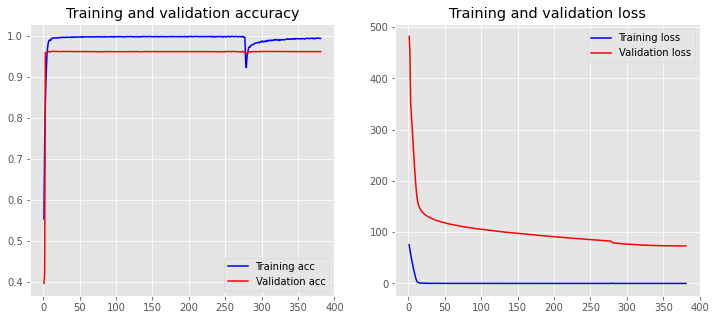

6/6 [==============================] - 4s 83ms/step
F1-score: 63.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7551020408163265,0.7551020408163265,0.7551020408163265,98.0
Apparatus-Descriptor,0.3333333333333333,0.5555555555555556,0.4166666666666667,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.375,0.23076923076923078,0.2857142857142857,13.0
Brand,0.2777777777777778,0.37037037037037035,0.3174603174603175,27.0
Characterization-Apparatus,0.07692307692307693,0.09090909090909091,0.08333333333333334,11.0
Condition-Misc,0.29411764705882354,0.75,0.42253521126760557,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.8924731182795699,0.9540229885057471,0.9222222222222222,87.0
Material,0.5626822157434402,0.6107594936708861,0.5857359635811836,316.0
Material-Descriptor,0.4772727272727273,0.47191011235955055,0.4745762711864407,89.0
Meta,0.21052631578947367,0.3076923076923077,0.25,13.0
Nonrecipe-Material,0.08333

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3489 words (3121 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 140, 100)          661100    
                                                                 
 bidirectional_39 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 832,392
Trainable params: 832,392
Non-trainable para

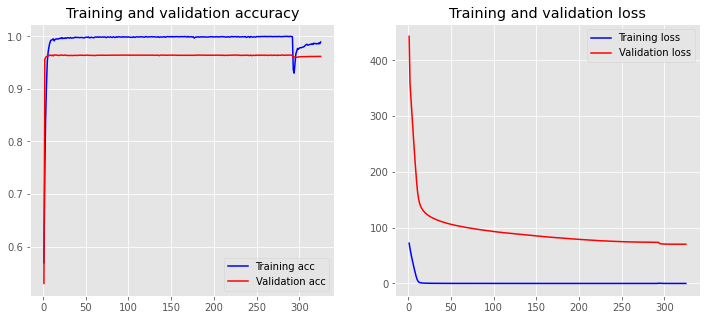

6/6 [==============================] - 4s 75ms/step
F1-score: 63.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6836734693877551,0.6836734693877551,0.6836734693877551,98.0
Apparatus-Descriptor,0.3333333333333333,0.4444444444444444,0.380952380952381,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.30612244897959184,0.5555555555555556,0.3947368421052632,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.43243243243243246,0.8,0.5614035087719298,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9186046511627907,0.9080459770114943,0.9132947976878613,87.0
Material,0.5440729483282675,0.5664556962025317,0.5550387596899224,316.0
Material-Descriptor,0.3888888888888889,0.39325842696629215,0.3910614525139665,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.08333333333333333,0.04,0.054054054054054

In [16]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3506 words (3124 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 140, 100)          663100    
                                                                 
 bidirectional_40 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 834,392
Trainable params: 834,392
Non-trainable para

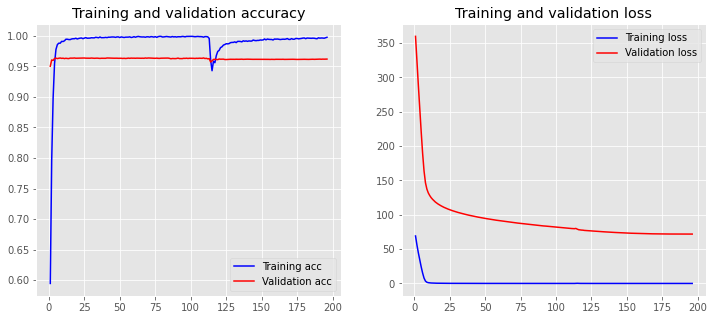

6/6 [==============================] - 4s 75ms/step
F1-score: 63.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.8105263157894737,0.7857142857142857,0.7979274611398963,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.42857142857142855,0.23076923076923078,0.3,13.0
Brand,0.21875,0.5185185185185185,0.30769230769230765,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9204545454545454,0.9310344827586207,0.9257142857142858,87.0
Material,0.5116883116883116,0.6234177215189873,0.5620542082738943,316.0
Material-Descriptor,0.425,0.38202247191011235,0.40236686390532544,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.8755760368663594,0.8962264150943396,0.88578088578

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3520 words (3127 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 140, 100)          664800    
                                                                 
 bidirectional_41 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 836,092
Trainable params: 836,092
Non-trainable para

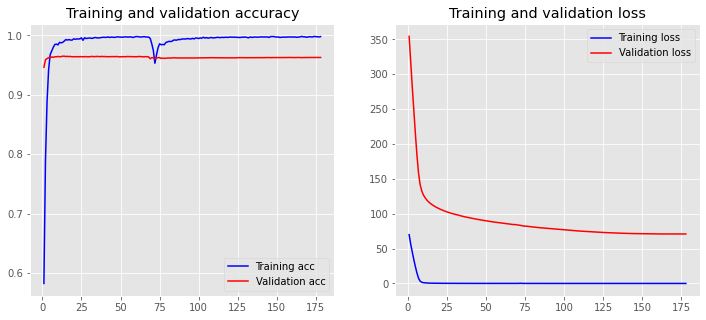

6/6 [==============================] - 4s 74ms/step
F1-score: 64.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7156862745098039,0.7448979591836735,0.7300000000000001,98.0
Apparatus-Descriptor,0.625,0.5555555555555556,0.5882352941176471,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.3333333333333333,0.5185185185185185,0.40579710144927533,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.3488372093023256,0.75,0.4761904761904763,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9195402298850575,0.9195402298850575,0.9195402298850575,87.0
Material,0.5421686746987951,0.569620253164557,0.5555555555555556,316.0
Material-Descriptor,0.47761194029850745,0.3595505617977528,0.4102564102564102,89.0
Meta,0.375,0.23076923076923078,0.2857142857142857,13.0
Nonrecipe-Material,0.14285714285714285,0.04,0.0625,25.0
N

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3518 words (3129 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 140, 100)          664800    
                                                                 
 bidirectional_42 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 836,092
Trainable params: 836,092
Non-trainable para

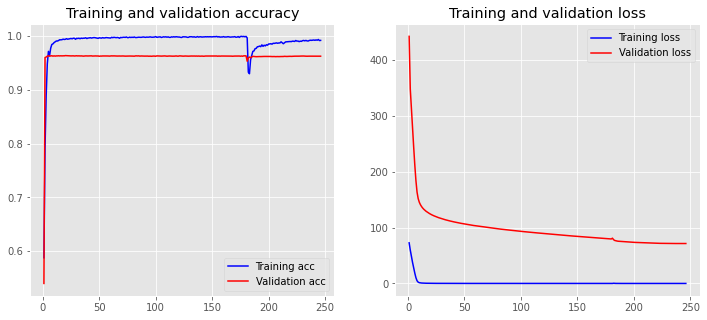

6/6 [==============================] - 4s 86ms/step
F1-score: 62.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7628865979381443,0.7551020408163265,0.7589743589743589,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.2,0.25925925925925924,0.22580645161290322,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.4838709677419355,0.75,0.5882352941176471,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9213483146067416,0.9425287356321839,0.9318181818181818,87.0
Material,0.5421686746987951,0.569620253164557,0.5555555555555556,316.0
Material-Descriptor,0.34408602150537637,0.3595505617977528,0.3516483516483517,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.05128205128205128,0.08,0.0625,25.0
Number,0.9158415841584159,0.8726415094339622,0.8937

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3502 words (3122 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 140, 100)          662500    
                                                                 
 bidirectional_43 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 833,792
Trainable params: 833,792
Non-trainable para

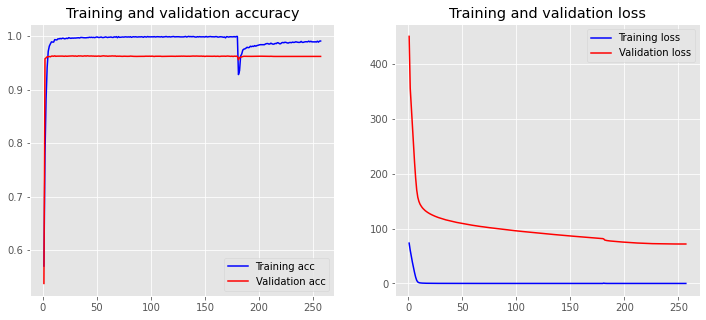

6/6 [==============================] - 4s 82ms/step
F1-score: 63.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7701149425287356,0.6836734693877551,0.7243243243243244,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.26666666666666666,0.14814814814814814,0.19047619047619047,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.4166666666666667,0.75,0.5357142857142857,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9213483146067416,0.9425287356321839,0.9318181818181818,87.0
Material,0.5232876712328767,0.6044303797468354,0.5609397944199705,316.0
Material-Descriptor,0.43902439024390244,0.4044943820224719,0.42105263157894735,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.09090909090909091,0.08,0.0851063829787234,25.0
Number,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3533 words (3133 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 140, 100)          666700    
                                                                 
 bidirectional_44 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 837,992
Trainable params: 837,992
Non-trainable para

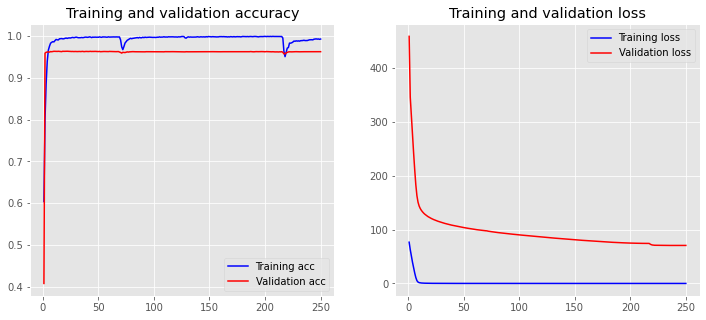

6/6 [==============================] - 3s 86ms/step
F1-score: 62.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7425742574257426,0.7653061224489796,0.7537688442211056,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.2962962962962963,0.2962962962962963,0.2962962962962963,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.23076923076923078,0.75,0.3529411764705882,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.8804347826086957,0.9310344827586207,0.9050279329608939,87.0
Material,0.510752688172043,0.6012658227848101,0.5523255813953487,316.0
Material-Descriptor,0.41379310344827586,0.4044943820224719,0.40909090909090906,89.0
Meta,0.25,0.3076923076923077,0.27586206896551724,13.0
Nonrecipe-Material,0.0714285714

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3526 words (3131 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 140, 100)          665800    
                                                                 
 bidirectional_45 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 837,092
Trainable params: 837,092
Non-trainable para

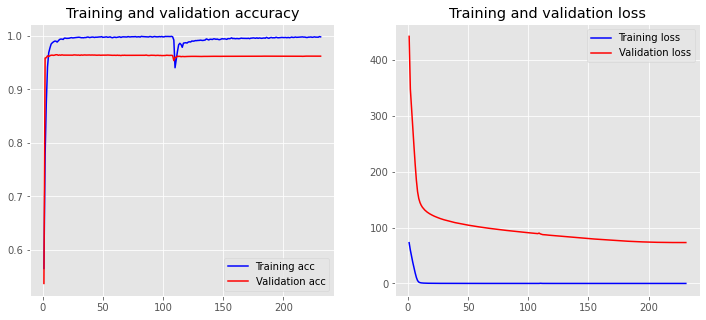

6/6 [==============================] - 4s 74ms/step
F1-score: 64.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.71,0.7244897959183674,0.7171717171717172,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.4,0.15384615384615385,0.2222222222222222,13.0
Brand,0.26666666666666666,0.2962962962962963,0.28070175438596495,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.48484848484848486,0.8,0.6037735849056605,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.898876404494382,0.9195402298850575,0.9090909090909091,87.0
Material,0.5167958656330749,0.6329113924050633,0.5689900426742532,316.0
Material-Descriptor,0.40404040404040403,0.449438202247191,0.425531914893617,89.0
Meta,0.4444444444444444,0.3076923076923077,0.3636363636363637,13.0
Nonrecipe-Material,0.2,0.08,0.11428571428571428,25.0
Number,0.9186602870813397,0.9056603773584

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3506 words (3119 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 140, 100)          662600    
                                                                 
 bidirectional_46 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 833,892
Trainable params: 833,892
Non-trainable para

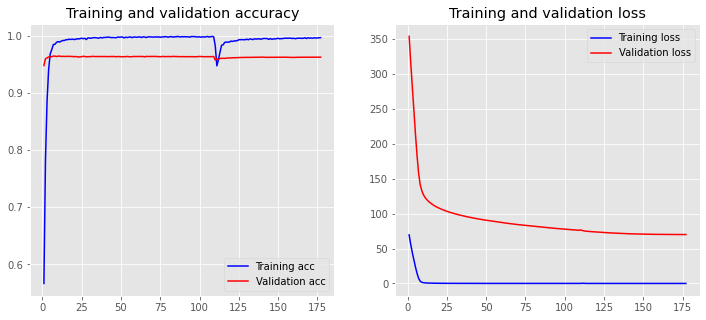

6/6 [==============================] - 4s 74ms/step
F1-score: 64.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7244897959183674,0.7244897959183674,0.7244897959183674,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.2972972972972973,0.4074074074074074,0.34375,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.4594594594594595,0.85,0.5964912280701754,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.8901098901098901,0.9310344827586207,0.9101123595505618,87.0
Material,0.49645390070921985,0.6645569620253164,0.5683355886332883,316.0
Material-Descriptor,0.45569620253164556,0.4044943820224719,0.42857142857142855,89.0
Meta,0.38461538461538464,0.38461538461538464,0.38461538461538464,13.0
Nonrecipe-Material,0.15384615384615385,0.08,0.10526315789473685,25.0
Nu

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3506 words (3124 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 140, 100)          663100    
                                                                 
 bidirectional_47 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 834,392
Trainable params: 834,392
Non-trainable para

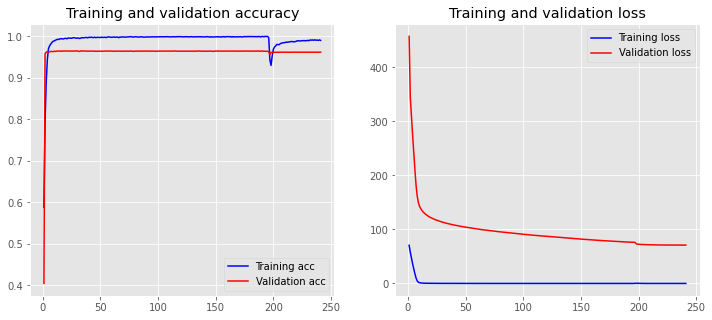

6/6 [==============================] - 3s 72ms/step
F1-score: 62.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.6666666666666666,0.6938775510204082,0.6799999999999999,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.17647058823529413,0.2222222222222222,0.19672131147540983,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5161290322580645,0.8,0.6274509803921569,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9010989010989011,0.9425287356321839,0.9213483146067416,87.0
Material,0.47743467933491684,0.6360759493670886,0.5454545454545454,316.0
Material-Descriptor,0.37349397590361444,0.34831460674157305,0.3604651162790698,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.88888888888

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3537 words (3128 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 140, 100)          666600    
                                                                 
 bidirectional_48 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 837,892
Trainable params: 837,892
Non-trainable para

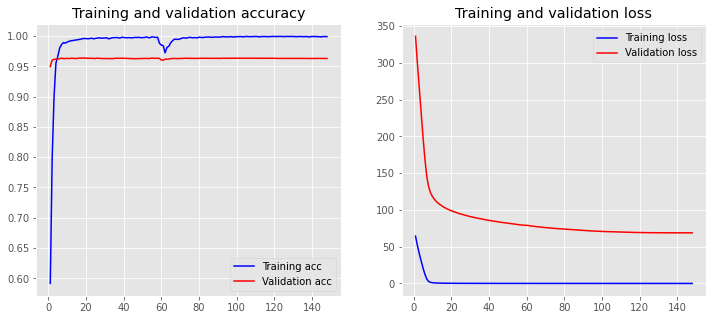

6/6 [==============================] - 3s 69ms/step
F1-score: 64.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.6826923076923077,0.7244897959183674,0.702970297029703,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.18421052631578946,0.25925925925925924,0.2153846153846154,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.43243243243243246,0.8,0.5614035087719298,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.8723404255319149,0.9425287356321839,0.9060773480662984,87.0
Material,0.5464788732394367,0.6139240506329114,0.5782414307004471,316.0
Material-Descriptor,0.4148936170212766,0.43820224719101125,0.4262295081967213,89.0
Meta,0.3333333333333333,0.23076923076923078,0.27272727272727276,13.0
Nonrecipe-Material,0.10714285714285714,0.12,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Converted 3527 words (3118 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 140, 100)          664600    
                                                                 
 bidirectional_49 (Bidirecti  (None, 140, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 140, 43)          8643      
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 140, 43)           1849      
                                                                 
Total params: 835,892
Trainable params: 835,892
Non-trainable para

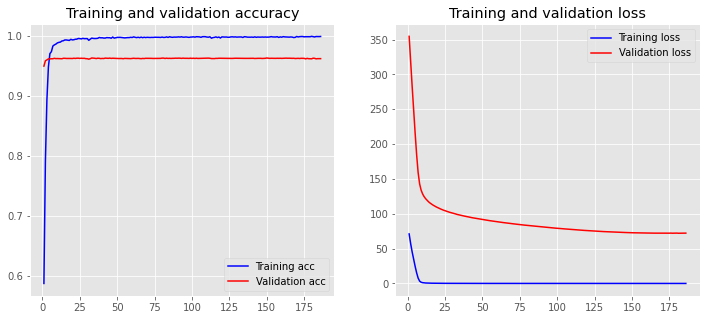

6/6 [==============================] - 4s 80ms/step
F1-score: 65.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7326732673267327,0.7551020408163265,0.743718592964824,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.3870967741935484,0.4444444444444444,0.41379310344827586,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.46875,0.75,0.5769230769230769,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9318181818181818,0.9425287356321839,0.9371428571428572,87.0
Material,0.5100502512562815,0.6424050632911392,0.5686274509803921,316.0
Material-Descriptor,0.4065934065934066,0.4157303370786517,0.41111111111111115,89.0
Meta,0.2727272727272727,0.23076923076923078,0.24999999999999994,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Numbe

In [17]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3576 words (3145 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 100)          672200    
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 140, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 140, 43)           1849      
                                                                 
Total params: 843,492
Trainable params: 843,492
Non-trainable params:

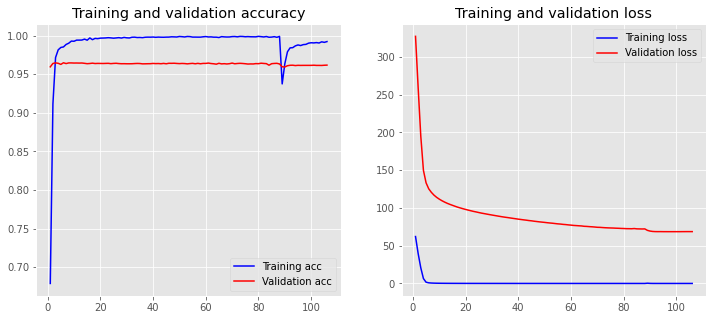

6/6 [==============================] - 4s 74ms/step
F1-score: 62.9%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7473684210526316,0.7244897959183674,0.7357512953367875,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.3157894736842105,0.2222222222222222,0.2608695652173913,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.45,0.9,0.6,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.8876404494382022,0.9080459770114943,0.8977272727272727,87.0
Material,0.5203761755485894,0.5253164556962026,0.5228346456692915,316.0
Material-Descriptor,0.4861111111111111,0.39325842696629215,0.43478260869565216,89.0
Meta,0.375,0.23076923076923078,0.2857142857142857,13.0
Nonrecipe-Material,0.17647058823529413,0.12,0.14285714285714282,25.0
Number,0.9424083769633508,0.8490566037735849,0.8933002481389578,212.0
Operation,0.7154150197628458,0.760

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3580 words (3148 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 100)          672900    
                                                                 
 bidirectional_1 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 844,192
Trainable params: 844,192
Non-trainable param

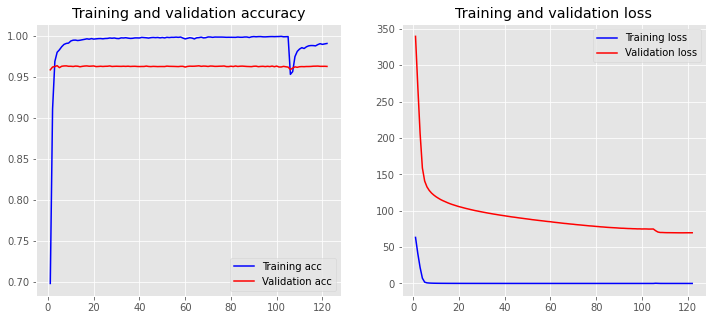

6/6 [==============================] - 4s 71ms/step
F1-score: 63.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7311827956989247,0.6938775510204082,0.7120418848167539,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.4,0.15384615384615385,0.2222222222222222,13.0
Brand,0.23809523809523808,0.18518518518518517,0.20833333333333334,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9195402298850575,0.9195402298850575,0.9195402298850575,87.0
Material,0.5283582089552239,0.560126582278481,0.5437788018433178,316.0
Material-Descriptor,0.3918918918918919,0.3258426966292135,0.3558282208588957,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.9

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3571 words (3154 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 100)          672600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 843,892
Trainable params: 843,892
Non-trainable param

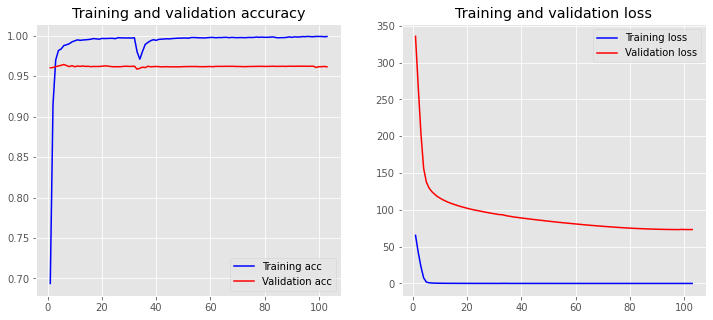

6/6 [==============================] - 4s 79ms/step
F1-score: 63.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7608695652173914,0.7142857142857143,0.7368421052631581,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.3333333333333333,0.25925925925925924,0.2916666666666667,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9302325581395349,0.9195402298850575,0.9248554913294798,87.0
Material,0.5097493036211699,0.5791139240506329,0.5422222222222223,316.0
Material-Descriptor,0.4482758620689655,0.29213483146067415,0.35374149659863946,89.0
Meta,0.375,0.23076923076923078,0.2857142857142857,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.8934010152284

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3583 words (3155 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 140, 100)          673900    
                                                                 
 bidirectional_3 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 845,192
Trainable params: 845,192
Non-trainable param

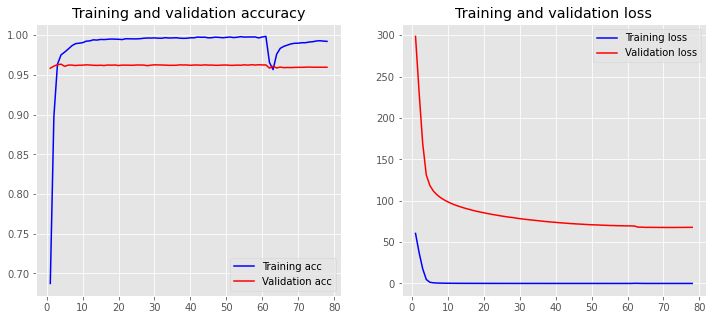

6/6 [==============================] - 4s 77ms/step
F1-score: 64.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7555555555555555,0.6938775510204082,0.723404255319149,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.13793103448275862,0.14814814814814814,0.14285714285714285,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5,0.85,0.6296296296296295,20.0
Condition-Type,0.25,1.0,0.4,1.0
Condition-Unit,0.8901098901098901,0.9310344827586207,0.9101123595505618,87.0
Material,0.544891640866873,0.5569620253164557,0.5508607198748043,316.0
Material-Descriptor,0.453125,0.3258426966292135,0.3790849673202615,89.0
Meta,0.4,0.3076923076923077,0.34782608695652173,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.9207920792079208,0.8773584905660378,0.8985507246376812,212.0
Operation,0.7346938775510204

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3589 words (3143 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 140, 100)          673300    
                                                                 
 bidirectional_4 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 844,592
Trainable params: 844,592
Non-trainable param

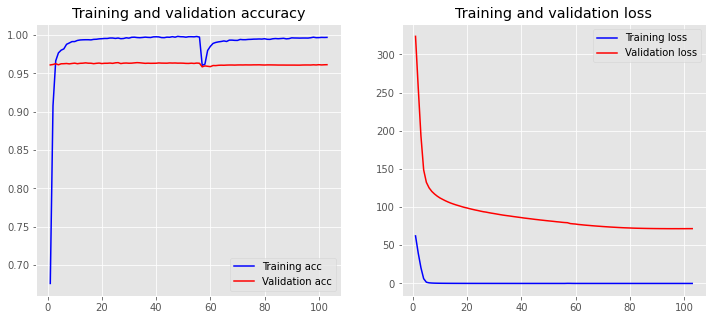

6/6 [==============================] - 4s 76ms/step
F1-score: 63.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7422680412371134,0.7346938775510204,0.7384615384615386,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.2631578947368421,0.37037037037037035,0.30769230769230765,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.46875,0.75,0.5769230769230769,20.0
Condition-Type,0.25,1.0,0.4,1.0
Condition-Unit,0.898876404494382,0.9195402298850575,0.9090909090909091,87.0
Material,0.5308641975308642,0.5443037974683544,0.5375000000000001,316.0
Material-Descriptor,0.42857142857142855,0.30337078651685395,0.35526315789473684,89.0
Meta,0.3333333333333333,0.23076923076923078,0.27272727272727276,13.0
Nonrecipe-Material,0.3333333333333333,0.04,0.07142857142857142,25.0
Number,0.9,0.84

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3587 words (3150 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 140, 100)          673800    
                                                                 
 bidirectional_5 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 845,092
Trainable params: 845,092
Non-trainable param

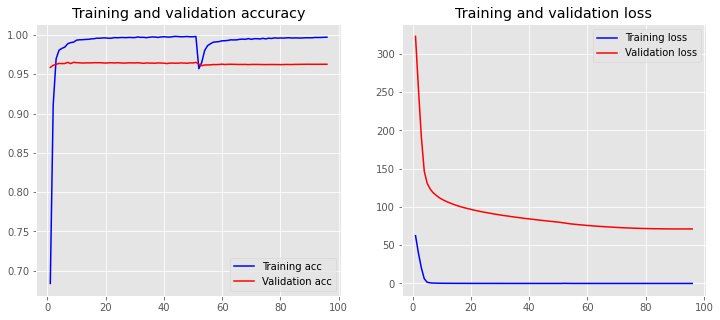

6/6 [==============================] - 4s 81ms/step
F1-score: 64.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7156862745098039,0.7448979591836735,0.7300000000000001,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.05714285714285714,0.07407407407407407,0.06451612903225806,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5,0.8,0.6153846153846154,20.0
Condition-Type,0.25,1.0,0.4,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.5571847507331378,0.6012658227848101,0.578386605783866,316.0
Material-Descriptor,0.4492753623188406,0.34831460674157305,0.3924050632911393,89.0
Meta,0.25,0.15384615384615385,0.1904761904761905,13.0
Nonrecipe-Material,0.18181818181818182,0.08,0.1111111111111111,25.0
Number,0.9146919431279

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3598 words (3152 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 140, 100)          675100    
                                                                 
 bidirectional_6 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 846,392
Trainable params: 846,392
Non-trainable param

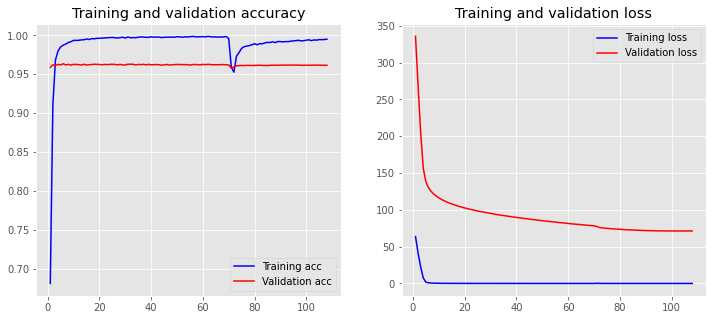

6/6 [==============================] - 4s 78ms/step
F1-score: 65.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7319587628865979,0.7244897959183674,0.7282051282051281,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.48,0.4444444444444444,0.4615384615384615,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.4358974358974359,0.85,0.5762711864406781,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9111111111111111,0.9425287356321839,0.9265536723163842,87.0
Material,0.5705329153605015,0.5759493670886076,0.5732283464566928,316.0
Material-Descriptor,0.43243243243243246,0.3595505617977528,0.39263803680981596,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.2727272727272727,0.12,0.16666666666666666,25.0
Numbe

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3585 words (3152 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 140, 100)          673800    
                                                                 
 bidirectional_7 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 845,092
Trainable params: 845,092
Non-trainable param

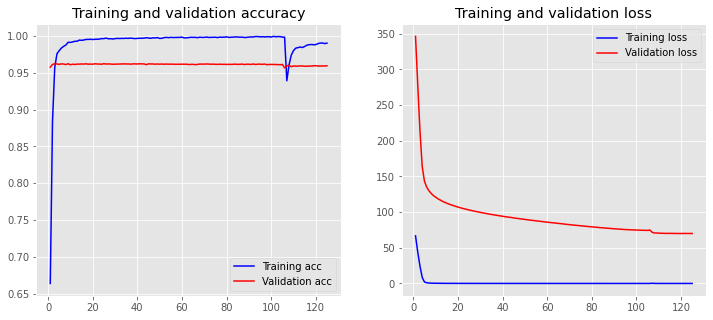

6/6 [==============================] - 4s 75ms/step
F1-score: 62.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7291666666666666,0.7142857142857143,0.7216494845360826,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.25,0.07692307692307693,0.11764705882352941,13.0
Brand,0.18518518518518517,0.18518518518518517,0.18518518518518517,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5,0.75,0.6,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9090909090909091,0.9195402298850575,0.9142857142857144,87.0
Material,0.525974025974026,0.5126582278481012,0.5192307692307693,316.0
Material-Descriptor,0.4520547945205479,0.3707865168539326,0.40740740740740733,89.0
Meta,0.25,0.15384615384615385,0.1904761904761905,13.0
Nonrecipe-Material,0.0,0.0,0.0,25.0
Number,0.9068627450980392,0.8726415094339622,0.8894230769230769,212.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3589 words (3155 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 140, 100)          674500    
                                                                 
 bidirectional_8 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 845,792
Trainable params: 845,792
Non-trainable param

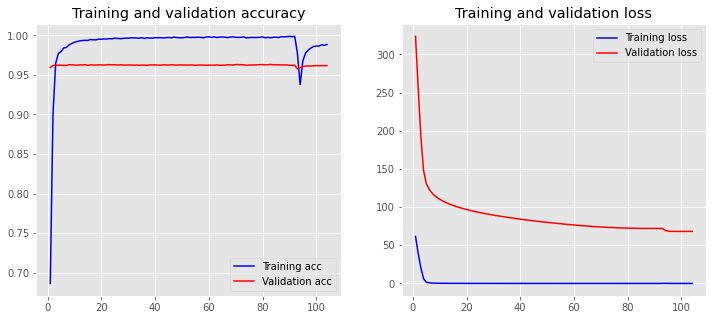

6/6 [==============================] - 4s 78ms/step
F1-score: 63.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7628865979381443,0.7551020408163265,0.7589743589743589,98.0
Apparatus-Descriptor,0.5,0.4444444444444444,0.47058823529411764,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.13333333333333333,0.07407407407407407,0.09523809523809523,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5172413793103449,0.75,0.6122448979591838,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.8901098901098901,0.9310344827586207,0.9101123595505618,87.0
Material,0.4704370179948586,0.5791139240506329,0.5191489361702128,316.0
Material-Descriptor,0.4266666666666667,0.3595505617977528,0.39024390243902435,89.0
Meta,0.3333333333333333,0.23076923076923078,0.27272727272727276,13.0
Nonrecipe-Material,0.0769230

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Converted 3591 words (3153 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 140, 100)          674500    
                                                                 
 bidirectional_9 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 140, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 140, 43)           1849      
                                                                 
Total params: 845,792
Trainable params: 845,792
Non-trainable param

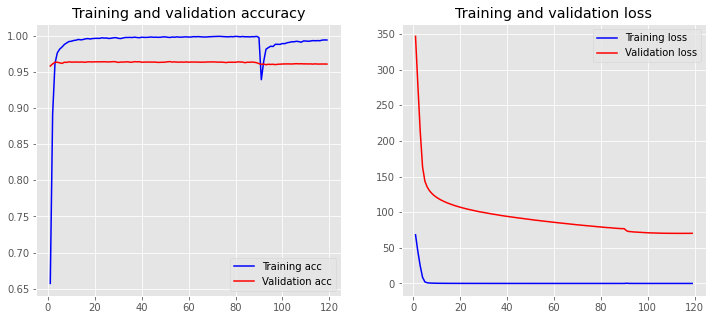

6/6 [==============================] - 4s 79ms/step
F1-score: 64.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.0,0.0,0.0,7.0
Amount-Unit,0.7448979591836735,0.7448979591836735,0.7448979591836735,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.2631578947368421,0.18518518518518517,0.21739130434782608,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.40540540540540543,0.75,0.5263157894736842,20.0
Condition-Type,0.25,1.0,0.4,1.0
Condition-Unit,0.898876404494382,0.9195402298850575,0.9090909090909091,87.0
Material,0.5159420289855072,0.5632911392405063,0.5385779122541604,316.0
Material-Descriptor,0.45161290322580644,0.3146067415730337,0.3708609271523179,89.0
Meta,0.36363636363636365,0.3076923076923077,0.33333333333333337,13.0
Nonrecipe-Material,0.0,0.0,0.

In [13]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)